In [2]:
import sys
sys.path.append('..')

In [3]:
import os
from tqdm import tqdm
import random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from collections import defaultdict

In [4]:
from sklearn.metrics import mean_squared_error
from scipy import stats

### Load Data

In [5]:
data_path = '/nethome/kgeorge/workspace/DomainPrediction/Data/fitness_prediction/GB1'

In [6]:
results_file = os.path.join(data_path, 'results_gb1_lowdata.csv')
df_results = pd.read_csv(results_file)

In [7]:
df_results

,seq,fitness_raw,split_id,n_mut,fitness_log,pred_esm2_mean_RF_d50_0,pred_esm2_mean_RF_d50_1,pred_esm2_mean_RF_d50_2,pred_esm2_mean_RF_d50_3,pred_esm2_mean_RF_d50_4,...,pred_esmc_confit_d100_0,pred_esmc_confit_d100_1,pred_esmc_confit_d100_2,pred_esmc_confit_d100_3,pred_esmc_confit_d100_4,pred_esmc_confit_d200_0,pred_esmc_confit_d200_1,pred_esmc_confit_d200_2,pred_esmc_confit_d200_3,pred_esmc_confit_d200_4
0,MQYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYD...,1.00,2,0,0.000000,-1.473586,-2.262141,-1.372218,-1.949208,-1.773654,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,MQYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGIDGEWTYD...,1.45,2,1,0.371564,-1.746167,-2.046158,-1.406960,-1.244626,-1.495042,...,0.125000,-1.625000,-0.250000,-0.125000,0.742188,-0.250000,0.250000,-0.750000,-0.250000,0.632812
2,MQYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGLDGEWTYD...,1.69,2,1,0.524729,-0.993532,-1.673021,-1.398244,-1.700001,-1.201924,...,-0.867188,0.125000,-1.437500,0.250000,-0.625000,-0.625000,-0.742188,0.742188,-0.187500,0.000000
3,MQYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGMDGEWTYD...,1.17,2,1,0.157004,-1.427161,-2.366460,-2.332480,-2.974432,-1.728525,...,-0.875000,-0.617188,-2.062500,0.250000,-1.000000,-1.375000,-1.500000,-0.750000,-1.054688,-0.929688
4,MQYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVAGEWTYD...,2.40,2,1,0.875469,-1.083356,-1.182996,-2.185544,-2.292232,-1.228218,...,0.250000,0.062500,0.062500,2.375000,0.250000,-0.812500,0.500000,2.046875,0.375000,0.125000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8728,MQYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGYYSEWTYD...,0.37,0,4,-0.994252,-4.481792,-3.434226,-3.773539,-5.942900,-8.066034,...,-3.000000,1.757812,-1.875000,0.453125,-4.304688,-1.750000,1.121094,-2.570312,-3.058594,-3.195312
8729,MQYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGYYVEWTYD...,1.04,0,4,0.039221,-2.880656,-3.208946,-5.678012,-2.722635,-6.708290,...,-3.617188,3.748047,0.132812,2.867188,-0.800781,-1.007812,1.687500,-1.761719,-1.507812,-4.054688
8730,MQYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGYYVEWTYD...,0.00,0,4,-13.815511,-3.609148,-4.512575,-8.116068,-5.050195,-7.508164,...,-9.820312,-4.472656,-2.929688,-3.554688,-7.074219,-6.328125,-3.781250,-7.007812,-5.917969,-7.617188
8731,MQYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGYYYEWTYD...,0.03,0,4,-3.506558,-4.944185,-3.883202,-5.886693,-5.550006,-7.220650,...,-4.441406,-0.371094,-3.695312,0.179688,-5.605469,-1.179688,-2.812500,-2.894531,-3.503906,-5.796875


In [8]:
df_results.columns.str.contains('pred').sum()

90

In [9]:
import pickle
file = os.path.join(data_path, 'sampled_gb1.pkl')
with open(file, 'rb') as f:
    sample_dict = pickle.load(f)

### Useful Functions

In [10]:
def get_spearmanr_bootstrap(a, b, n=1000, ci = 95):
    assert len(a) == len(b)
    corr = []
    p_values = []
    np.random.seed(0)
    for _ in range(n):
        indices = np.random.choice(len(a), size=len(a), replace=True)
        res = stats.spearmanr(a[indices], b[indices])
        
        if not np.isnan(res.statistic):
            corr.append(res.statistic)
            p_values.append(res.pvalue)

    ci_lower, ci_upper = np.percentile(corr, [100-ci, ci]) 
    mean_corr = np.mean(corr)
    p_value = np.mean(np.array(corr) < 0)

    return round(mean_corr, 2), round(ci_lower, 2), round(ci_upper, 2), round(p_value, 2), corr, p_values

In [11]:
def get_split_mask(df, omit_zero=False):
    if omit_zero:
        train_mask = (df['split_id'] == 2) & (df['fitness_raw'] != 0)
    else:
        train_mask = (df['split_id'] == 2)

    val_mask = df['split_id'] == 1
    test_mask = df['split_id'] == 0

    return train_mask, val_mask, test_mask

In [12]:
name_dict = {
        'pred_OHE_ridge': 'OHE Linear',
        'pred_OHE_RF': 'OHE RF',
        'pred_OHE_MLP': 'OHE MLP',

        'pred_esm2_mean_ridge': 'ESM2 mean-embeddings Linear',
        'pred_esm2_mean_RF': 'ESM2 mean-embeddings RF',
        'pred_esm2_mean_MLP': 'ESM2 mean-embeddings MLP',
        'pred_esm2_concat_ridge': 'ESM2 concat-embeddings Linear',
        'pred_esm2_concat_RF': 'ESM2 concat-embeddings RF',

        'pred_esmc_mean_ridge': 'ESMC mean-embeddings Linear',
        'pred_esmc_mean_RF': 'ESMC mean-embeddings RF',
        'pred_esmc_mean_MLP': 'ESMC mean-embeddings MLP',
        'pred_esmc_concat_ridge': 'ESMC concat-embeddings Linear',
        'pred_esmc_concat_RF': 'ESMC concat-embeddings RF',

        'pred_esm2_wt_marginal': 'ESM2 wildtype marginal',
        'pred_esm2_masked_marginal': 'ESM2 masked marginal',
        'pred_esm2_pseudolikelihood': 'ESM2 pseudolikelihood',

        'pred_esmc_wt_marginal': 'ESMC wildtype marginal',
        'pred_esmc_masked_marginal': 'ESMC masked marginal',
        'pred_esmc_pseudolikelihood': 'ESMC pseudolikelihood',

        'pred_esm2_regfit': 'ESM2 regression finetuning',
        'pred_esmc_regfit': 'ESMC regression finetuning',

        'pred_esm2_confit': 'ESM2 contrastive finetuning',
        'pred_esmc_confit': 'ESMC contrastive finetuning',
        
    }

### Plots

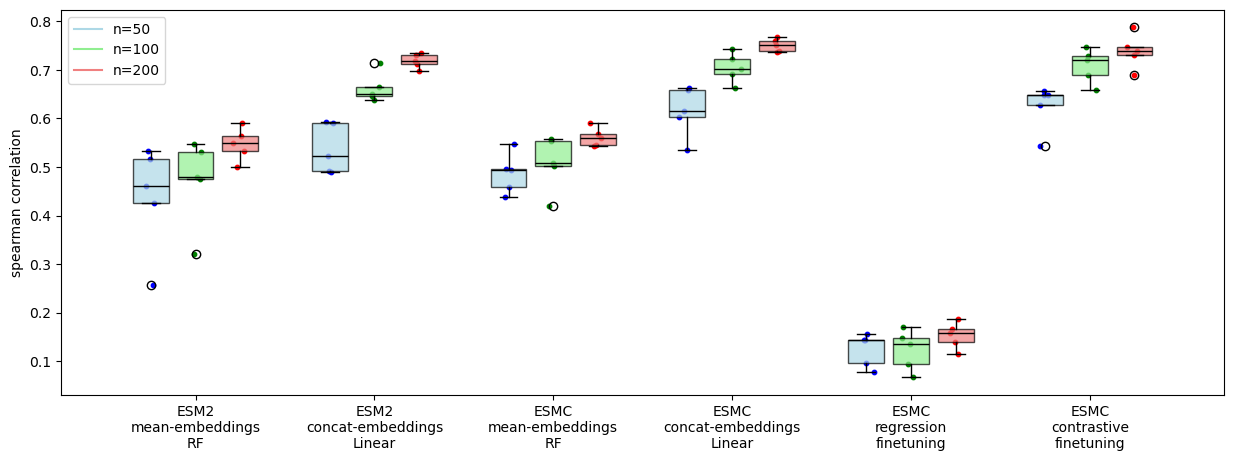

In [13]:
models = ['pred_esm2_mean_RF', 'pred_esm2_concat_ridge', 'pred_esmc_mean_RF', 'pred_esmc_concat_ridge', 'pred_esmc_regfit', 'pred_esmc_confit']
label = 'fitness_log'

fig, ax = plt.subplots(figsize=(15,5))

for i, _m in enumerate(models):
    corr_box = []
    for dps in [50, 100, 200]:
        corr = []
        for fold in range(5):
            suffix = f'_d{dps}_{fold}'
            assert _m + suffix in df_results

            res = stats.spearmanr(df_results[label].to_numpy(), df_results[_m + suffix].to_numpy())
            assert not np.isnan(res.statistic)
            corr.append(res.statistic)

        corr_box.append(corr)

    _pos = [i-0.25, i, i+0.25]
    bp = ax.boxplot(corr_box, positions=_pos, widths=0.2, patch_artist=True, boxprops=dict(color='black'),
                    medianprops=dict(color='black'),
                    whiskerprops=dict(color='black'),
                    capprops=dict(color='black')) #, labels = ['', name_dict[_m].replace(' ', '\n'), ''])
    
    for patch, color in zip(bp['boxes'], ['lightblue', 'lightgreen', 'lightcoral']):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    # Plot individual points
    for j, (corrs, color) in enumerate(zip(corr_box, ['blue', 'green', 'red'])):
        x = np.random.normal(_pos[j], 0.02, size=len(corrs))
        ax.scatter(x, corrs, color=color, alpha=1.0, s=10)

ax.plot([], c='lightblue', label='n=50')
ax.plot([], c='lightgreen', label='n=100')
ax.plot([], c='lightcoral', label='n=200')

ax.legend()
ax.set_ylabel('spearman correlation')
ax.set_xticks([i for i in range(6)])
ax.set_xticklabels([name_dict[_m].replace(' ', '\n') for _m in models])

plt.show()

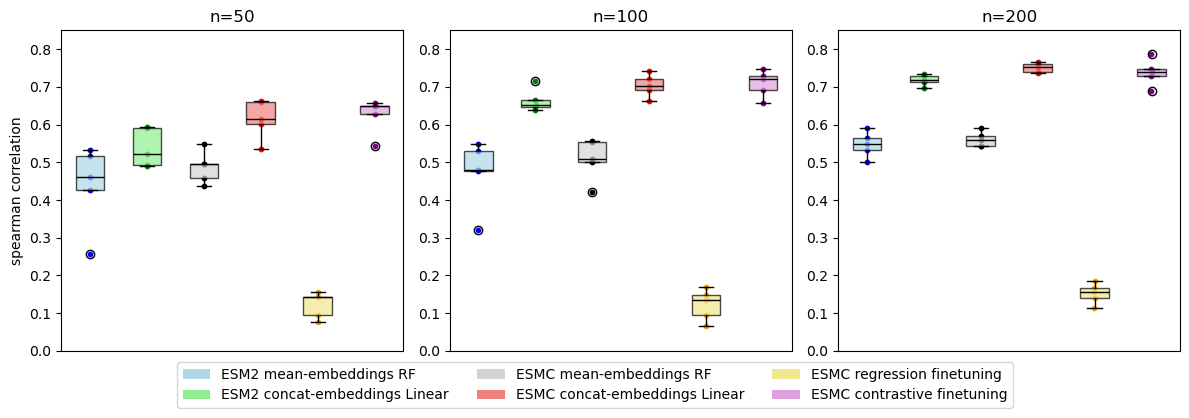

In [16]:
models = ['pred_esm2_mean_RF', 'pred_esm2_concat_ridge', 'pred_esmc_mean_RF', 'pred_esmc_concat_ridge', 'pred_esmc_regfit', 'pred_esmc_confit']
label = 'fitness_log'

fig, ax = plt.subplots(1, 3, figsize=(12,4))

for i, dps in enumerate([50, 100, 200]):
    corr_box = []
    for _m in models:
        corr = []
        for fold in range(5):
            suffix = f'_d{dps}_{fold}'
            assert _m + suffix in df_results

            res = stats.spearmanr(df_results[label].to_numpy(), df_results[_m + suffix].to_numpy())
            assert not np.isnan(res.statistic)
            corr.append(res.statistic)

        corr_box.append(corr)

    bp = ax[i].boxplot(corr_box, patch_artist=True, boxprops=dict(color='black'),
                    medianprops=dict(color='black'),
                    whiskerprops=dict(color='black'),
                    capprops=dict(color='black'))
    
    for patch, color in zip(bp['boxes'], ['lightblue', 'lightgreen', 'lightgray', 'lightcoral', 'khaki', 'plum']):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    # Plot individual points
    for j, (corrs, color) in enumerate(zip(corr_box, ['blue', 'green', 'black', 'red', 'orange', 'purple'])):
        x = np.random.normal(j+1, 0.002, size=len(corrs))
        ax[i].scatter(x, corrs, color=color, alpha=1.0, s=10)

    ax[i].set_title(f'n={dps}')

# for _c, _m in zip(['lightblue', 'lightgreen', 'lightgray', 'lightcoral', 'khaki', 'plum'], [name_dict[_m] for _m in models]):
#     ax[0].plot([], c=_c, label=_m)

ax[0].bar([1, 1, 1, 1, 1 , 1], [0, 0, 0, 0, 0, 0], color=['lightblue', 'lightgreen', 'lightgray', 'lightcoral', 'khaki', 'plum'], label=[name_dict[_m] for _m in models])

handles, labels = ax[0].get_legend_handles_labels()  # assuming all axes share same legend
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.05), ncol=3)

# ax[0].legend()
ax[0].set_ylabel('spearman correlation')

for i in range(3):
    ax[i].set_xticks([])
    ax[i].set_ylim((0, 0.85))

plt.tight_layout()
plt.subplots_adjust(bottom=0.11)
plt.show()